# Fine-Tuned U-Net

In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt

### Class

In [2]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_size=(256, 256)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = sorted(os.listdir(images_dir))
        self.image_size = image_size

        self.img_transform = T.Compose([
            T.Resize(image_size),
            T.ToTensor()
        ])

        self.mask_transform = T.Compose([
            T.Resize(image_size),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = os.path.splitext(img_name)[0] + ".png"

        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        mask  = Image.open(mask_path).convert("L")

        image = self.img_transform(image)
        mask = self.mask_transform(mask)
        mask = (mask > 0).float()  # binary mask 0/1

        return image, mask


### Folders

In [ ]:
base = "/home/liva/segmentation_preparation/data/datasets" # this folder might be called segmentation_resnet instead of segmentation_preparation in Javid's files as I changed the name in the end

train_dataset = SegmentationDataset(f"{base}/train/images", f"{base}/train/masks")
train_loader  = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = SegmentationDataset(f"{base}/val/images", f"{base}/val/masks")
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)

test_dataset = SegmentationDataset(f"{base}/test/images", f"{base}/test/masks")
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Fine-Tuned U-Net Model
- deeper encoder: 4 encoder blocks instead of three
- added batch normalization
- symmetric skip connections

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), # added batch normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), #  added batch normalization
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

# 4 encoder blocks instead of 3
class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()
        # Down
        self.d1 = DoubleConv(in_ch, 32)
        self.d2 = DoubleConv(32, 64)
        self.d3 = DoubleConv(64, 128)
        self.d4 = DoubleConv(128, 256) # added this encoder block
        self.pool = nn.MaxPool2d(2)
        # Up
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.u3 = DoubleConv(128+128, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.u2 = DoubleConv(64+64, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.u1 = DoubleConv(32+32, 32)
        self.out = nn.Conv2d(32, out_ch, 1)
    def forward(self, x):
        c1 = self.d1(x)
        x = self.pool(c1)
        c2 = self.d2(x)
        x = self.pool(c2)
        c3 = self.d3(x)
        x = self.pool(c3)
        x = self.d4(x) # and here also added depth
        x = self.up3(x)
        x = torch.cat([x, c3], dim=1) # skip connections
        x = self.u3(x)
        x = self.up2(x)
        x = torch.cat([x, c2], dim=1) # skip connections
        x = self.u2(x)
        x = self.up1(x)
        x = torch.cat([x, c1], dim=1) # skip connections
        x = self.u1(x)
        return self.out(x)

### Defining functions to be called in training loop

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(in_ch=3, out_ch=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def dice_loss(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    return 1 - ((2*intersection + smooth)/(union + smooth)).mean()

def iou_score(preds, targets, threshold=0.5, smooth=1e-6):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - intersection
    return ((intersection + smooth) / (union + smooth)).mean().item()

### Training Details (tracking and hyperparameters)

In [6]:
# Lists to store metrics
train_losses = []
val_losses = []
val_ious = []

# earlier stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

# epoch nums
num_epochs = 40

## Training

In [7]:
for epoch in range(num_epochs):
    # training
    model.train()
    train_loss_total = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks  = masks.to(device)
        preds = model(images)
        loss = criterion(preds, masks) + dice_loss(preds, masks) # checks out how good a prediction is 
        optimizer.zero_grad() # model weights are changed
        loss.backward()
        optimizer.step()
        train_loss_total += loss.item()
    #  save metrics
    train_loss = train_loss_total / len(train_loader)
    train_losses.append(train_loss)

    # validating
    model.eval()
    val_loss_total = 0
    val_iou_total = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks  = masks.to(device)
            preds = model(images)
            loss = criterion(preds, masks) + dice_loss(preds, masks)
            val_loss_total += loss.item()
            val_iou_total += iou_score(preds, masks)
    # save metrics
    val_loss = val_loss_total / len(val_loader)
    val_losses.append(val_loss)
    val_iou = val_iou_total / len(val_loader)
    val_ious.append(val_iou)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val IoU: {val_iou:.4f}")
    print("-"*30)

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

Epoch 1/40
Train Loss: 1.1042
Val Loss: 1.0279
Val IoU: 0.5047
------------------------------
Epoch 2/40
Train Loss: 0.9712
Val Loss: 0.9171
Val IoU: 0.5397
------------------------------
Epoch 3/40
Train Loss: 0.9097
Val Loss: 0.8555
Val IoU: 0.5435
------------------------------
Epoch 4/40
Train Loss: 0.8573
Val Loss: 0.7972
Val IoU: 0.5654
------------------------------
Epoch 5/40
Train Loss: 0.8078
Val Loss: 0.8236
Val IoU: 0.5511
------------------------------
Epoch 6/40
Train Loss: 0.7616
Val Loss: 0.7364
Val IoU: 0.5736
------------------------------
Epoch 7/40
Train Loss: 0.7314
Val Loss: 0.7160
Val IoU: 0.5771
------------------------------
Epoch 8/40
Train Loss: 0.7018
Val Loss: 0.6931
Val IoU: 0.5793
------------------------------
Epoch 9/40
Train Loss: 0.6776
Val Loss: 0.6868
Val IoU: 0.5738
------------------------------
Epoch 10/40
Train Loss: 0.6564
Val Loss: 0.6459
Val IoU: 0.5949
------------------------------
Epoch 11/40
Train Loss: 0.6192
Val Loss: 0.6495
Val IoU: 0.

## Plotting Training & Validation Loss and IoU Development

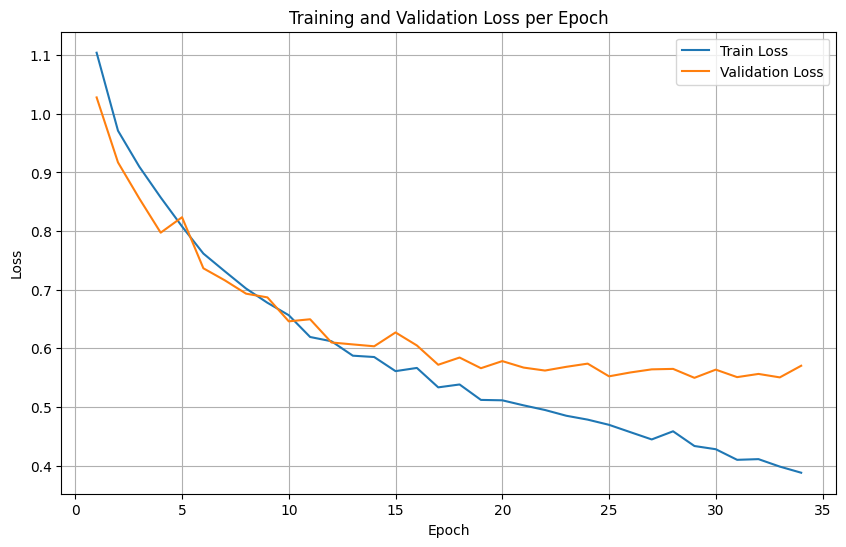

In [8]:
# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

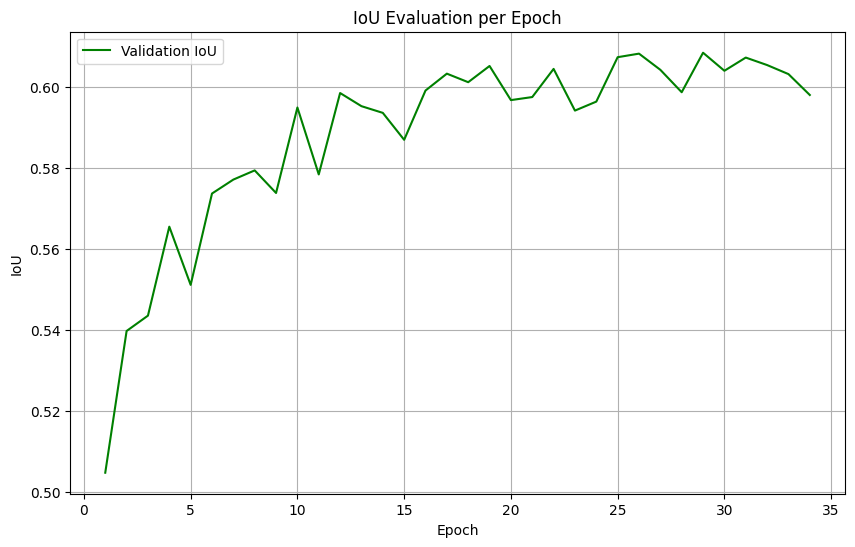

In [9]:
# Plot IoU per epoch
plt.figure(figsize=(10,6))
plt.plot(range(1, len(val_ious)+1), val_ious, label="Validation IoU", color='green')
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("IoU Evaluation per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Compute Mean IoU

In [10]:
def compute_iou(pred, mask):
    pred = (pred > 0.5).float()
    mask = (mask > 0.5).float()

    intersection = (pred * mask).sum()
    union = ((pred + mask) > 0).float().sum()

    if union == 0:
        return 1.0 # if no corrosion is present

    return float((intersection / union).item())

In [11]:
model.eval()
ious = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks  = masks.to(device)

        # predictions
        preds = torch.sigmoid(model(images))

        # convert to binary
        preds_binary = (preds > 0.5).float()

        # compute IoU#
        iou = compute_iou(preds_binary, masks)
        ious.append(iou)

#  mean iou statistics
mean_iou = sum(ious) / len(ious)

print(f"Test set size: {len(ious)} images")
print(f"Mean IoU over test set: {mean_iou:.4f}")
print(f"IoU range: min={min(ious):.4f}, max={max(ious):.4f}")


Test set size: 123 images
Mean IoU over test set: 0.6417
IoU range: min=0.0637, max=0.9323


## Print examples of image, true mask, predicted mask

In [12]:
# get one batch
images, masks = next(iter(val_loader))
images = images.to(device)
masks = masks.to(device)

with torch.no_grad():
    preds = model(images)
    preds = torch.sigmoid(preds)   # convert 0-1
    preds_binary = (preds > 0.5).float()  # threshold to binary mask


In [13]:
def show_predictions(model, dataloader, device, n=3, threshold=0.5):
    """
    Displays n RGB images, their true masks, and predicted masks
    """
    model.eval()
    rgb_batch, mask_batch = next(iter(dataloader))
    
    rgb_batch = rgb_batch.to(device)
    
    with torch.no_grad():
        preds = torch.sigmoid(model(rgb_batch))  # probabilities
        preds = (preds > threshold).float()      # binary mask
    
    # move to CPU and convert to numpy
    rgb_batch = rgb_batch.cpu()
    mask_batch = mask_batch.cpu()
    preds = preds.cpu()
    
    for i in range(min(n, len(rgb_batch))):
        rgb_img = rgb_batch[i].permute(1,2,0).numpy()
        true_mask = mask_batch[i][0].numpy()
        pred_mask = preds[i][0].numpy()
        
        fig, axes = plt.subplots(1,3, figsize=(12,4))
        axes[0].imshow(rgb_img)
        axes[0].set_title("RGB Image")
        axes[0].axis("off")
        
        axes[1].imshow(true_mask, cmap="gray")
        axes[1].set_title("True Mask")
        axes[1].axis("off")
        
        axes[2].imshow(pred_mask, cmap="gray")
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")
        
        plt.show()

In [ ]:
show_predictions(model, val_loader, device, n=3)

## Visualize specific example

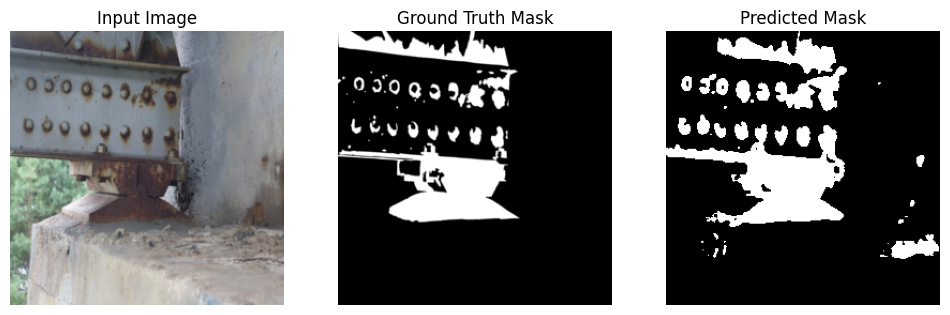

In [14]:
# folder name
target_name = "cl725bfgn4nz9073849m9b4v4"

# get paths
img_path  = os.path.join(base, "test/images", target_name + ".jpg")  # image is jpg
mask_path = os.path.join(base, "test/masks",  target_name + ".png")  # mask is png

# load image and mask
image = Image.open(img_path).convert("RGB")
mask  = Image.open(mask_path).convert("L")

# transform to tensor (add batch dimension)
img_tensor = train_dataset.img_transform(image).unsqueeze(0).to(device)  # [1, C, H, W]
mask_tensor = train_dataset.mask_transform(mask).unsqueeze(0).to(device) # [1, 1, H, W]

# predict with model
model.eval()
with torch.no_grad():
    pred = model(img_tensor)
    pred_binary = (torch.sigmoid(pred) > 0.5).float()

# remove batch dimension
img_np = img_tensor[0].cpu().permute(1,2,0)
mask_np = mask_tensor[0].cpu().squeeze()
pred_np = pred_binary[0].cpu().squeeze()

# print
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(mask_np, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred_np, cmap="gray")
plt.axis("off")
plt.show()

In [15]:
# compute IoU for this specific image
intersection = ((pred_binary > 0) & (mask_tensor > 0)).float().sum()
union = ((pred_binary > 0) | (mask_tensor > 0)).float().sum()

iou = (intersection / union).item() if union > 0 else 0.0

print(f"IoU for {target_name}: {iou:.4f}")

IoU for cl725bfgn4nz9073849m9b4v4: 0.7204
